# Subject-Level Repeatability Analysis

This notebook analyzes the consistency of subject-level model performance.

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [10]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Change to 'POST' for post-decision analysis
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.models.fusion import weighted_late_fusion

np.random.seed(42)
sns.set_style('whitegrid')

print(f"\n{'='*70}")
print(f"SUBJECT REPEATABILITY ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


SUBJECT REPEATABILITY ANALYSIS: PRE-DECISION PERIOD



## Load Data


In [11]:
# Load subject accuracy data from late fusion model results
accuracy_df = pd.read_csv(f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_model_{TIMEFRAME}_subject_accuracies.csv')
print(f"Accuracy data: {accuracy_df.shape}")
print(f"Columns: {accuracy_df.columns.tolist()}")
accuracy_df.head()

Accuracy data: (97, 2)
Columns: ['subject_id', 'accuracy']


,subject_id,accuracy
0,0806_1000_539136F,0.533898
1,0806_1000_U9TEJGM,0.687023
2,0811_1000_4LI8GO7,0.661157
3,0811_1000_539136F,0.723077
4,0811_1000_U9TEJGM,0.793893


In [12]:
# Load session mapping with proper dtypes
session_mapping = pd.read_csv('../../data/results/session_mapping.csv', 
                              dtype={'mmdd': str, 'hhmm': str, 'user_id': str})
print(f"\nSession mapping: {session_mapping.shape}")
print(f"Columns: {session_mapping.columns.tolist()}")
session_mapping.head()


Session mapping: (99, 9)
Columns: ['filename', 'date', 'time', 'user_id', 'mmdd', 'hhmm', 'team', 'session', 'visit_number']


,filename,date,time,user_id,mmdd,hhmm,team,session,visit_number
0,preprocessing_0816_1400_9M4VCHG.json,08/16/2021,14:00,9M4VCHG,0816,1400,Team 12,Session 3,2.0
1,preprocessing_0924_1600_9M4VCHG.json,09/24/2021,16:00,9M4VCHG,0924,1600,Team 24,Session 3,3.0
2,preprocessing_0825_1000_9M4VCHG.json,08/25/2021,10:00,9M4VCHG,0825,1000,Team 17,Session 2,2.0
3,preprocessing_0813_1600_539136F.json,08/13/2021,16:00,539136F,0813,1600,Team 12,Session 2,1.0
4,preprocessing_0826_1000_539136F.json,08/26/2021,10:00,539136F,0826,1000,Team 17,Session 3,3.0


## Merge Data


In [13]:
# Create join key in session_mapping
session_mapping['join_key'] = session_mapping['mmdd'] + '_' + session_mapping['hhmm'] + '_' + session_mapping['user_id']

# Use subject_id from accuracy_df as join_key (already in mmdd_hhmm_userid format)
merged_df = accuracy_df.merge(
    session_mapping[['join_key', 'visit_number']],
    left_on='subject_id',
    right_on='join_key',
    how='left'
)

print(f"Merged data: {merged_df.shape}")
print(f"\nRecords with visit_number: {merged_df['visit_number'].notna().sum()} / {len(merged_df)}")
merged_df.head()


Merged data: (97, 4)

Records with visit_number: 91 / 97


,subject_id,accuracy,join_key,visit_number
0,0806_1000_539136F,0.533898,0806_1000_539136F,1.0
1,0806_1000_U9TEJGM,0.687023,0806_1000_U9TEJGM,1.0
2,0811_1000_4LI8GO7,0.661157,0811_1000_4LI8GO7,NaN
3,0811_1000_539136F,0.723077,0811_1000_539136F,NaN
4,0811_1000_U9TEJGM,0.793893,0811_1000_U9TEJGM,NaN


## Compute Team Total Visits


In [14]:
session_mapping

,filename,date,time,user_id,mmdd,hhmm,team,session,visit_number,join_key
0,preprocessing_0816_1400_9M4VCHG.json,08/16/2021,14:00,9M4VCHG,0816,1400,Team 12,Session 3,2.0,0816_1400_9M4VCHG
1,preprocessing_0924_1600_9M4VCHG.json,09/24/2021,16:00,9M4VCHG,0924,1600,Team 24,Session 3,3.0,0924_1600_9M4VCHG
2,preprocessing_0825_1000_9M4VCHG.json,08/25/2021,10:00,9M4VCHG,0825,1000,Team 17,Session 2,2.0,0825_1000_9M4VCHG
3,preprocessing_0813_1600_539136F.json,08/13/2021,16:00,539136F,0813,1600,Team 12,Session 2,1.0,0813_1600_539136F
4,preprocessing_0826_1000_539136F.json,08/26/2021,10:00,539136F,0826,1000,Team 17,Session 3,3.0,0826_1000_539136F
...,...,...,...,...,...,...,...,...,...,...
94,preprocessing_0824_1000_U9TEJGM.json,08/24/2021,10:00,U9TEJGM,0824,1000,Team 17,Session 1,1.0,0824_1000_U9TEJGM
95,preprocessing_1005_1600_9M4VCHG.json,10/05/2021,16:00,9M4VCHG,1005,1600,Team 26,Session 3,2.0,1005_1600_9M4VCHG
96,preprocessing_0831_1300_539136F.json,08/31/2021,13:00,539136F,0831,1300,Team 21,Session 2,2.0,0831_1300_539136F
97,preprocessing_0915_1000_U9TEJGM.json,09/15/2021,10:00,U9TEJGM,0915,1000,Team 22,Session 1,1.0,0915_1000_U9TEJGM


In [15]:
# First, add team and other info to merged_df
merged_df = merged_df.merge(
    session_mapping[['join_key', 'team', 'session']],
    left_on='subject_id',
    right_on='join_key',
    how='left',
    suffixes=('', '_session')
)

# Count total visits per team (max visit number for each team)
team_visit_counts = session_mapping.groupby('team')['visit_number'].max().reset_index()
team_visit_counts.columns = ['team', 'team_total_visits']

# Add to merged_df
merged_df = merged_df.merge(team_visit_counts, on='team', how='left')

# Extract desktop_id from subject_id (last part after second underscore)
merged_df['desktop_id'] = merged_df['subject_id'].str.split('_').str[2]

print("Team total visits distribution:")
print(merged_df[merged_df['team_total_visits'].notna()]['team_total_visits'].value_counts().sort_index())
merged_df[['subject_id', 'team', 'session', 'visit_number', 'team_total_visits', 'desktop_id']].head(10)

Team total visits distribution:
team_total_visits
1.0    14
2.0    52
3.0    25
Name: count, dtype: int64


,subject_id,team,session,visit_number,team_total_visits,desktop_id
0,0806_1000_539136F,Team 8,Session 3,1.0,1.0,539136F
1,0806_1000_U9TEJGM,Team 8,Session 3,1.0,1.0,U9TEJGM
2,0811_1000_4LI8GO7,NaN,NaN,NaN,NaN,4LI8GO7
3,0811_1000_539136F,NaN,NaN,NaN,NaN,539136F
4,0811_1000_U9TEJGM,NaN,NaN,NaN,NaN,U9TEJGM
5,0813_1000_539136F,Team 10,Session 3,1.0,1.0,539136F
6,0813_1000_9M4VCHG,Team 10,Session 3,1.0,1.0,9M4VCHG
7,0813_1000_U9TEJGM,Team 10,Session 3,1.0,1.0,U9TEJGM
8,0813_1600_539136F,Team 12,Session 2,1.0,2.0,539136F
9,0813_1600_9M4VCHG,Team 12,Session 2,1.0,2.0,9M4VCHG


## Analysis: Accuracy by Visit Number


Accuracy by Visit Number:
                  mean       std  count       sem
visit_number                                     
1.0           0.656005  0.115825     49  0.016546
2.0           0.702599  0.165550     34  0.028392
3.0           0.649523  0.201951      8  0.071401


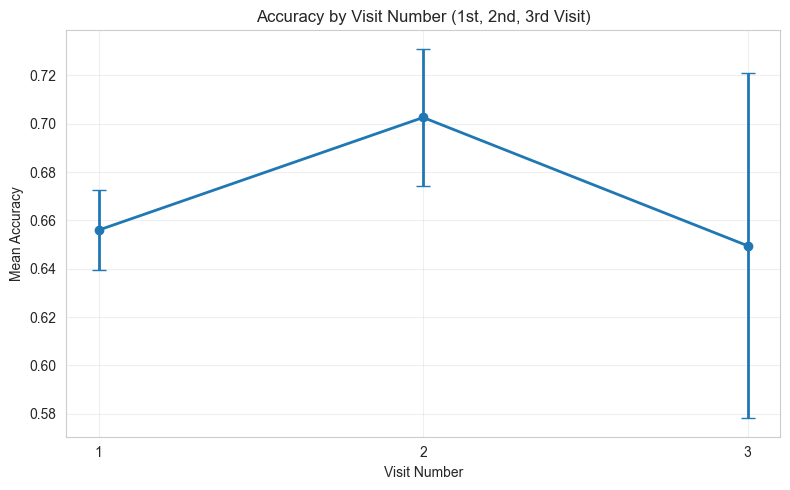

In [16]:
# Filter to records with visit_number
analysis_df = merged_df[merged_df['visit_number'].notna()].copy()

# Group by visit number
visit_accuracy = analysis_df.groupby('visit_number')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Visit Number:")
print(visit_accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(visit_accuracy.index, visit_accuracy['mean'], 
             yerr=visit_accuracy['sem'], marker='o', capsize=5, linewidth=2)
plt.xlabel('Visit Number')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Visit Number (1st, 2nd, 3rd Visit)')
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Analysis: Accuracy by Team Total Visits


Accuracy by Team Total Visits:
                       mean       std  count       sem
team_total_visits                                     
1.0                0.645024  0.082570     14  0.022068
2.0                0.669808  0.159696     52  0.022146
3.0                0.694737  0.139887     25  0.027977


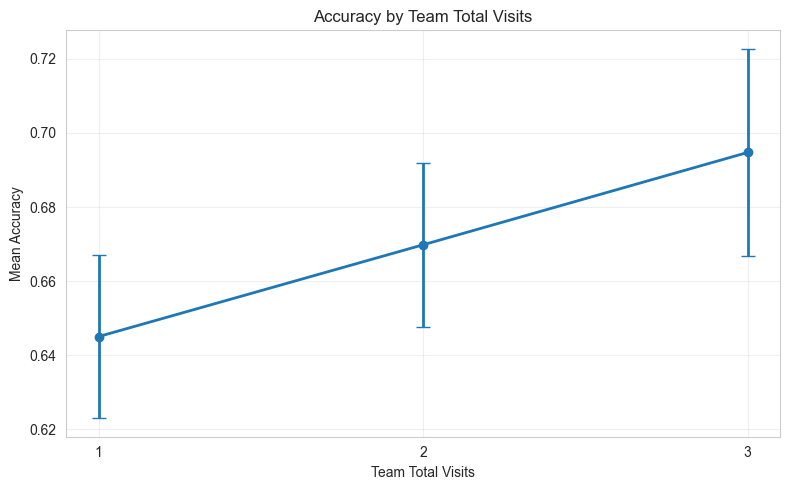

In [17]:
# Group by team total visits
team_visits_accuracy = analysis_df.groupby('team_total_visits')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Team Total Visits:")
print(team_visits_accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.errorbar(team_visits_accuracy.index, team_visits_accuracy['mean'], 
             yerr=team_visits_accuracy['sem'], marker='o', capsize=5, linewidth=2)
plt.xlabel('Team Total Visits')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Team Total Visits')
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Analysis: Accuracy by Desktop ID


Accuracy by Desktop ID:
                mean       std  count       sem
desktop_id                                     
539136F     0.689097  0.163026     31  0.029280
U9TEJGM     0.667409  0.113513     30  0.020725
9M4VCHG     0.661484  0.155171     30  0.028330


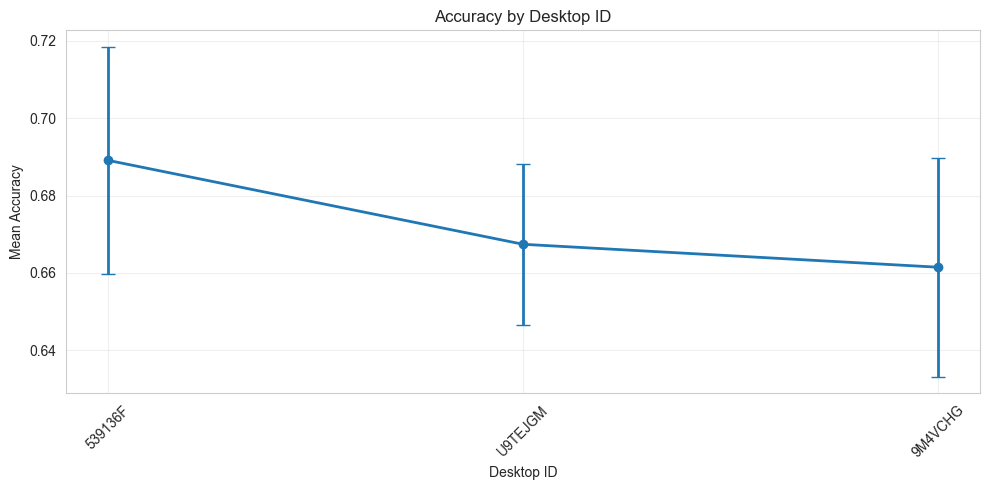

In [18]:
# Group by desktop ID
desktop_accuracy = analysis_df.groupby('desktop_id')['accuracy'].agg(['mean', 'std', 'count', 'sem'])
print("Accuracy by Desktop ID:")
print(desktop_accuracy.sort_values('mean', ascending=False))

# Plot
plt.figure(figsize=(10, 5))
desktop_accuracy_sorted = desktop_accuracy.sort_values('mean', ascending=False)
plt.errorbar(range(len(desktop_accuracy_sorted)), desktop_accuracy_sorted['mean'], 
             yerr=desktop_accuracy_sorted['sem'], marker='o', capsize=5, linewidth=2)
plt.xticks(range(len(desktop_accuracy_sorted)), desktop_accuracy_sorted.index, rotation=45)
plt.xlabel('Desktop ID')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy by Desktop ID')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Interaction: Visit Number x Team Total Visits


Accuracy by Visit Number x Team Total Visits:
                                    mean  count       sem
visit_number team_total_visits                           
1.0          1.0                0.645024     14  0.022068
             2.0                0.640050     26  0.027524
             3.0                0.719179      9  0.016107
2.0          2.0                0.699567     26  0.034243
             3.0                0.712455      8  0.050219
3.0          3.0                0.649523      8  0.071401


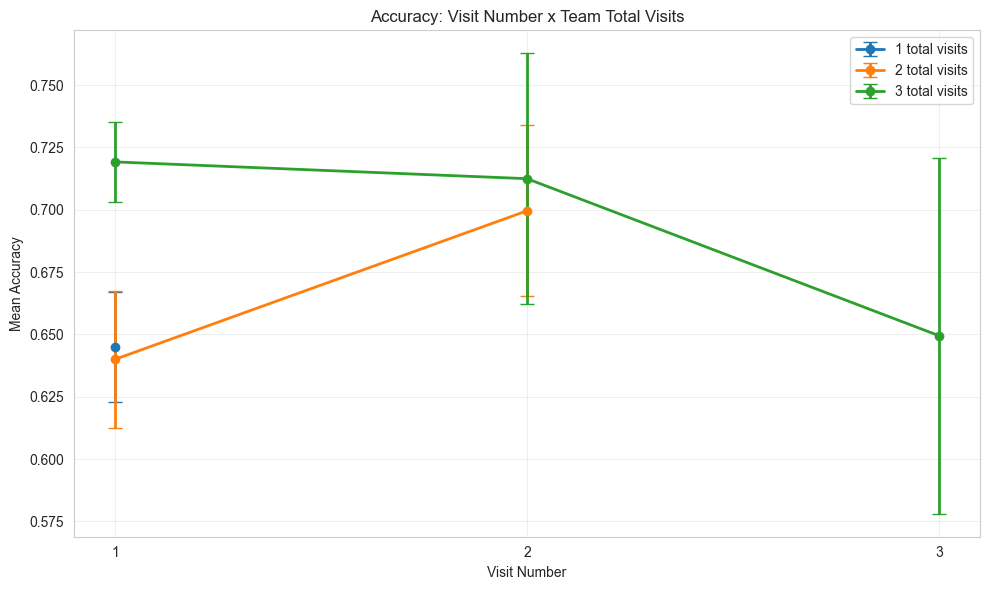

In [19]:
# Crosstab analysis
interaction = analysis_df.groupby(['visit_number', 'team_total_visits'])['accuracy'].agg(['mean', 'count', 'sem'])
print("Accuracy by Visit Number x Team Total Visits:")
print(interaction)

# Plot
plt.figure(figsize=(10, 6))
for total_visits in sorted(analysis_df['team_total_visits'].unique()):
    subset = interaction.xs(total_visits, level='team_total_visits')
    plt.errorbar(subset.index, subset['mean'], yerr=subset['sem'], 
                marker='o', capsize=5, linewidth=2, label=f'{int(total_visits)} total visits')

plt.xlabel('Visit Number')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy: Visit Number x Team Total Visits')
plt.legend()
plt.xticks([1, 2, 3])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visualizations: Subject Accuracies by Visit Number


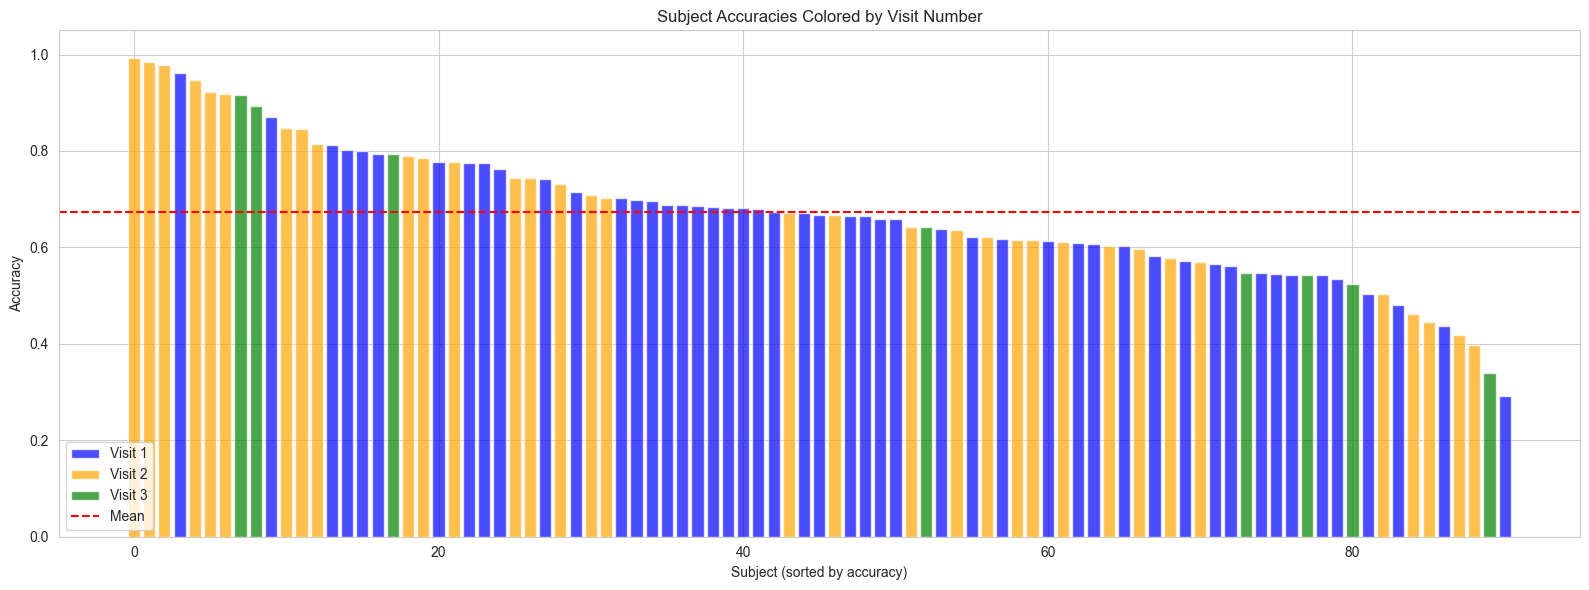

In [20]:
# Bar chart of all subject accuracies, colored by visit number
visit_colors = {1.0: 'blue', 2.0: 'orange', 3.0: 'green'}
analysis_df_sorted = analysis_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(16, 6))
colors = [visit_colors.get(v, 'gray') for v in analysis_df_sorted['visit_number']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Visit Number')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='red', linestyle='--', label='Mean')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.7, label='Visit 1'),
    Patch(facecolor='orange', alpha=0.7, label='Visit 2'),
    Patch(facecolor='green', alpha=0.7, label='Visit 3'),
    plt.Line2D([0], [0], color='red', linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()


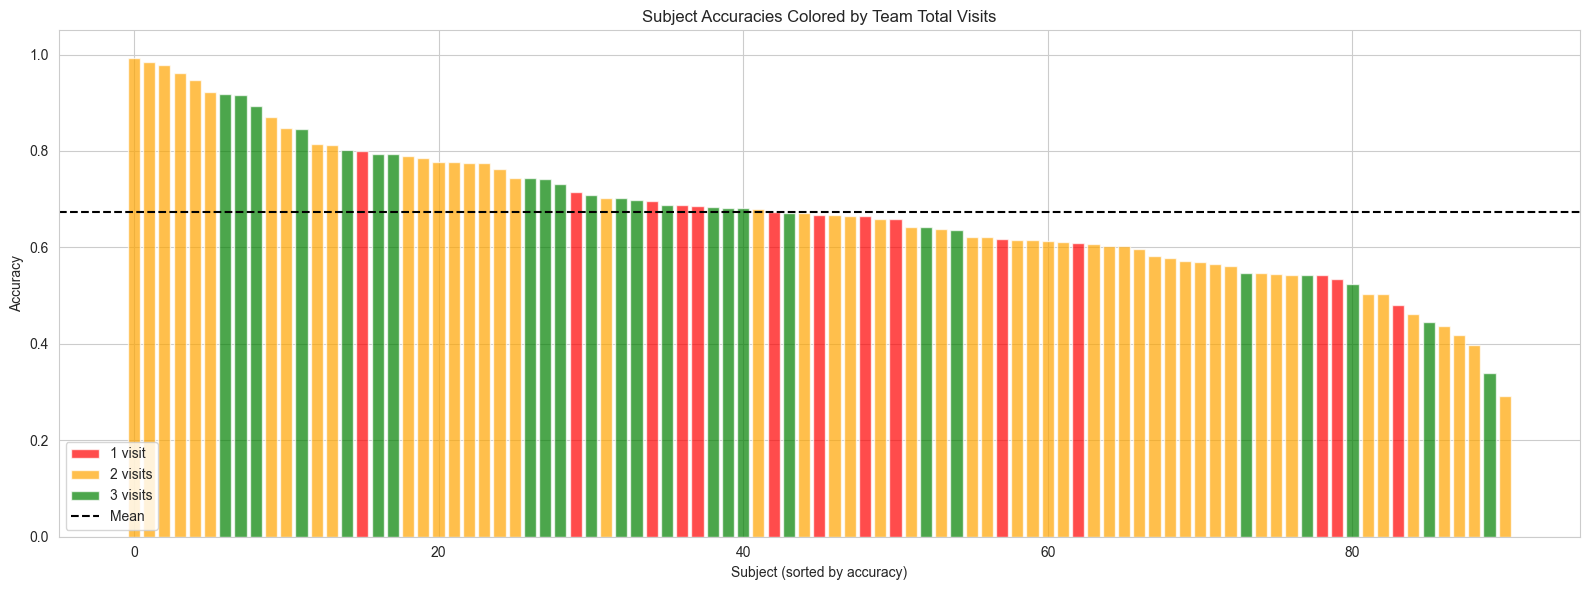

In [21]:
# Bar chart colored by team total visits
team_colors = {1.0: 'red', 2.0: 'orange', 3.0: 'green'}

plt.figure(figsize=(16, 6))
colors = [team_colors.get(v, 'gray') for v in analysis_df_sorted['team_total_visits']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Team Total Visits')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='black', linestyle='--', label='Mean')

# Legend
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='1 visit'),
    Patch(facecolor='orange', alpha=0.7, label='2 visits'),
    Patch(facecolor='green', alpha=0.7, label='3 visits'),
    plt.Line2D([0], [0], color='black', linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()


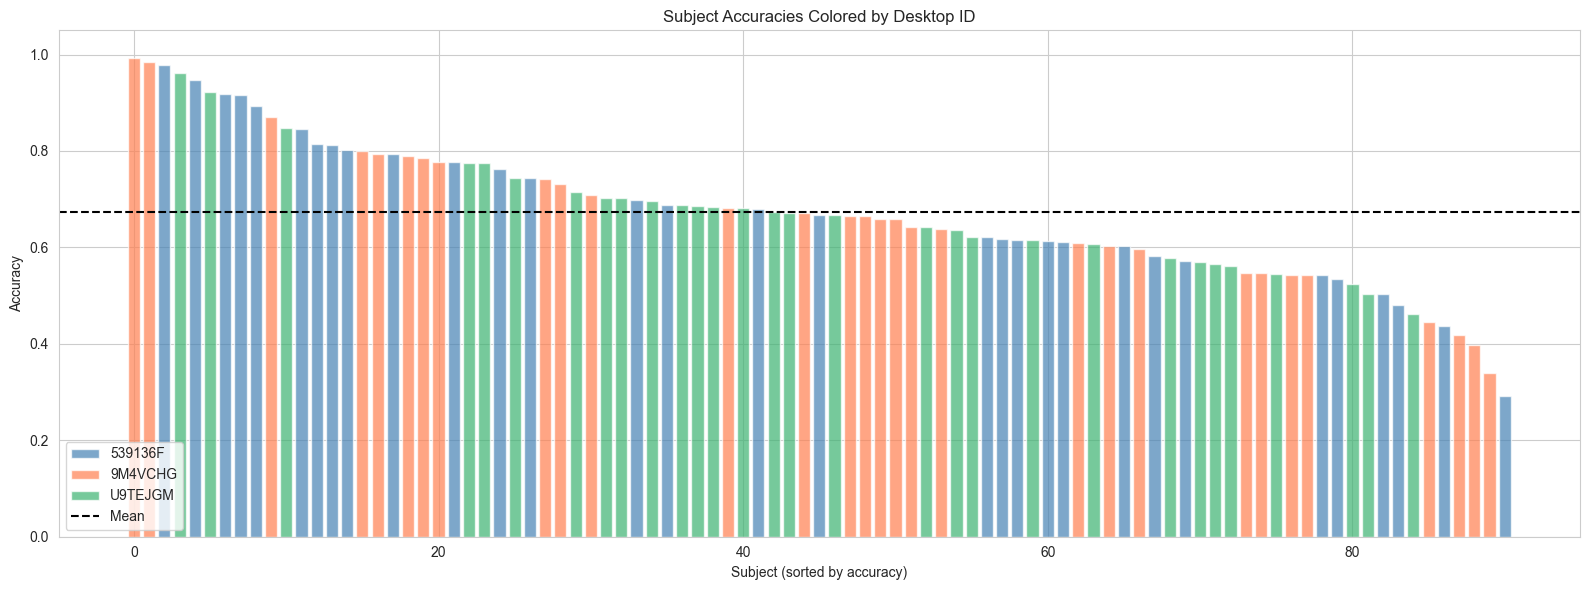

In [22]:
# Bar chart colored by desktop ID
desktop_colors = {
    '539136F': 'steelblue',
    '9M4VCHG': 'coral',
    'U9TEJGM': 'mediumseagreen',
    'A6I5HI6': 'purple',
    '4LI8GO7': 'gold'
}

plt.figure(figsize=(16, 6))
colors = [desktop_colors.get(d, 'gray') for d in analysis_df_sorted['desktop_id']]
plt.bar(range(len(analysis_df_sorted)), analysis_df_sorted['accuracy'], color=colors, alpha=0.7)
plt.xlabel('Subject (sorted by accuracy)')
plt.ylabel('Accuracy')
plt.title('Subject Accuracies Colored by Desktop ID')
plt.ylim(0, 1.05)
plt.axhline(y=analysis_df_sorted['accuracy'].mean(), color='black', linestyle='--', label='Mean')

# Legend
legend_elements = [
    Patch(facecolor=desktop_colors.get(d, 'gray'), alpha=0.7, label=d) 
    for d in sorted(analysis_df['desktop_id'].unique())
]
legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mean'))
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()


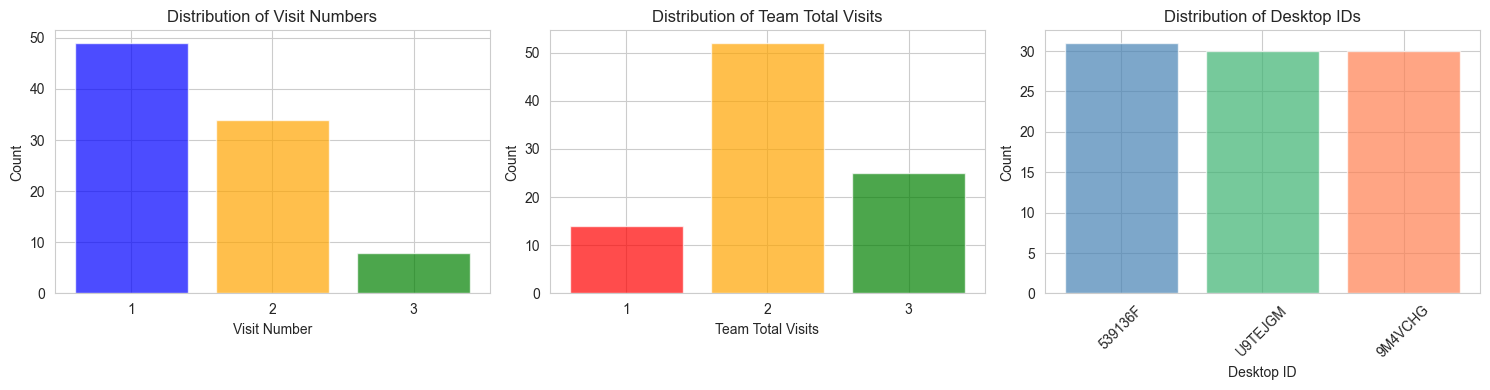

In [23]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Visit number distribution
visit_counts = analysis_df['visit_number'].value_counts().sort_index()
axes[0].bar(visit_counts.index, visit_counts.values, color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_xlabel('Visit Number')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Visit Numbers')
axes[0].set_xticks([1, 2, 3])

# Team total visits distribution
team_counts = analysis_df['team_total_visits'].value_counts().sort_index()
axes[1].bar(team_counts.index, team_counts.values, color=['red', 'orange', 'green'], alpha=0.7)
axes[1].set_xlabel('Team Total Visits')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Team Total Visits')
axes[1].set_xticks([1, 2, 3])

# Desktop ID distribution
desktop_counts = analysis_df['desktop_id'].value_counts()
colors_desktop = [desktop_colors.get(d, 'gray') for d in desktop_counts.index]
axes[2].bar(range(len(desktop_counts)), desktop_counts.values, color=colors_desktop, alpha=0.7)
axes[2].set_xlabel('Desktop ID')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Desktop IDs')
axes[2].set_xticks(range(len(desktop_counts)))
axes[2].set_xticklabels(desktop_counts.index, rotation=45)

plt.tight_layout()
plt.show()


## Save Results to CSV

Exporting all results for later analysis without re-running.

In [24]:
import os
os.makedirs(f'../../data/results/fusion_model_results_{TIMEFRAME}', exist_ok=True)

# Save analysis results
if 'visit_accuracy' in locals():
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/subject_repeat_{TIMEFRAME}_accuracy_by_visit.csv'
    visit_accuracy.to_csv(output_file)
    print(f"✓ Saved visit accuracy to: {output_file}")

if 'team_visits_accuracy' in locals():
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/subject_repeat_{TIMEFRAME}_accuracy_by_team_visits.csv'
    team_visits_accuracy.to_csv(output_file)
    print(f"✓ Saved team visits accuracy to: {output_file}")

if 'desktop_accuracy' in locals():
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/subject_repeat_{TIMEFRAME}_accuracy_by_desktop.csv'
    desktop_accuracy.to_csv(output_file)
    print(f"✓ Saved desktop accuracy to: {output_file}")

if 'interaction' in locals():
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/subject_repeat_{TIMEFRAME}_interaction_visit_team.csv'
    interaction.to_csv(output_file)
    print(f"✓ Saved interaction analysis to: {output_file}")

if 'merged_df' in locals():
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/subject_repeat_{TIMEFRAME}_merged_data.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"✓ Saved merged data to: {output_file}")

print(f"\n✓ All results saved to: ../../data/results/fusion_model_results_{TIMEFRAME}/")

✓ Saved visit accuracy to: ../../data/results/fusion_model_results_PRE/subject_repeat_PRE_accuracy_by_visit.csv
✓ Saved team visits accuracy to: ../../data/results/fusion_model_results_PRE/subject_repeat_PRE_accuracy_by_team_visits.csv
✓ Saved desktop accuracy to: ../../data/results/fusion_model_results_PRE/subject_repeat_PRE_accuracy_by_desktop.csv
✓ Saved interaction analysis to: ../../data/results/fusion_model_results_PRE/subject_repeat_PRE_interaction_visit_team.csv
✓ Saved merged data to: ../../data/results/fusion_model_results_PRE/subject_repeat_PRE_merged_data.csv

✓ All results saved to: ../../data/results/fusion_model_results_PRE/
